In [4]:
import torch
# import torch_directml
# select the GPU device if available
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch_directml.is_available():
#     device = torch_directml.device(torch_directml.default_device())
else:
    device = torch.device("cpu")
device

device(type='cpu')

In [12]:
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

# Dataset 2: https://www.kaggle.com/code/faressayah/chest-x-ray-medical-diagnosis-with-cnn-densenet/input

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Load train data 
train_data = datasets.ImageFolder(root='data/chest_xray/chest_xray/train', transform=transform)
test_data = datasets.ImageFolder(root='data/chest_xray/chest_xray/test', transform=transform)
val_data = datasets.ImageFolder(root='data/chest_xray/chest_xray/val', transform=transform)

In [13]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=4)  
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=4)

torch.Size([10, 1, 256, 256])


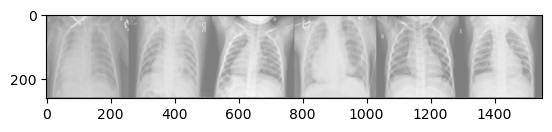

labels: tensor([1, 1, 0, 1, 0, 0])


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
it = iter(train_loader)
x, y = next(it)

print(x.shape)

# show images
imshow(torchvision.utils.make_grid(x[:6]))
print('labels:', y[:6])

In [26]:
import os

num_positive = len(os.listdir(os.path.join('data/chest_xray/chest_xray/train', 'PNEUMONIA')))
num_negative = len(os.listdir(os.path.join('data/chest_xray/chest_xray/train', 'NORMAL')))

# Class weights

positives_weight = num_positive / (num_negative + num_positive)
negatives_weight = num_negative / (num_negative + num_positive)

class_weight = {0: positives_weight, 1: negatives_weight}

print(f"Positives weight: {positives_weight:.2f}")
print(f"Negatives weight: {negatives_weight:.2f}")

Positives weight: 0.74
Negatives weight: 0.26


In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class ConvNet(nn.Module):    
    def __init__(self, num_classes):
        super().__init__()
        self.pipeline = nn.Sequential(
            # 256x256
            nn.Conv2d(1, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 128x128
            nn.Conv2d(64, 48, kernel_size=3, stride=2),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
            # 64x64
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            # 32x32
            nn.Conv2d(48, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # 16x16
            nn.Conv2d(32, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            # 8x8
            nn.Conv2d(16, num_classes, kernel_size=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(7*7, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.pipeline(x)
        x = self.classifier(x.flatten(1))
        x = torch.sigmoid(x)
        return x

In [27]:
import torch.optim as optim

def get_weighted_binary_loss(pos_weight, neg_weight):
    def weighted_binary_loss(outputs, targets):
        cost = neg_weight * targets * torch.log(1.0 - outputs) 
        cost += pos_weight * (1-targets) * torch.log(outputs)           
        return torch.neg(cost.mean())
    return weighted_binary_loss


num_classes = 1
model = ConvNet(num_classes)
model.to(device)

loss_fn = get_weighted_binary_loss(positives_weight, negatives_weight)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_params = sum(p.numel() for p in model.parameters())
num_params

47203

In [28]:
PATH = './mnist_medical.pth'
train_losses = []
val_losses = []
accuracies = []
epochs = []

In [51]:
from utils import RunningAverage

num_epochs = 5

for ep in range(num_epochs):
    train_acc = RunningAverage()
    train_loss = RunningAverage()
    model.train()
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = loss_fn(outputs, labels.float())

        # backward & optimize
        loss.backward()
        optimizer.step()

        # statistics
        train_loss.update(loss.item())
    
    train_losses.append(train_loss())
    
    model.eval()
    total = 0        
    correct = 0 
    val_loss = RunningAverage()
    acc = RunningAverage()
    for i, data in enumerate(val_loader):
        images, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = loss_fn(outputs, labels.float())

        val_loss.update(loss)

        preds = outputs > 0.5
        total = labels.size(0)
        correct = (preds == labels).sum().item()

        acc.update(correct/total)
    
    accuracies.append(acc())
    val_losses.append(val_loss())

    print(f'[{ep + 1}] train_loss: {train_loss():05.3f}, val_loss: {val_loss():05.3f}, accuracy: {acc() * 100:2.0f}%')

    epochs.append(ep)
    torch.save(model.state_dict(), PATH)

print('Finished Training')

/home/hgoz/anaconda3/envs/06-image/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1] train_loss: 0.056, val_loss: 0.590, accuracy: 38%
[2] train_loss: 0.054, val_loss: 0.532, accuracy: 47%
[3] train_loss: 0.056, val_loss: 0.529, accuracy: 30%
[4] train_loss: 0.054, val_loss: 0.539, accuracy: 55%
[5] train_loss: 0.054, val_loss: 0.414, accuracy: 38%
Finished Training


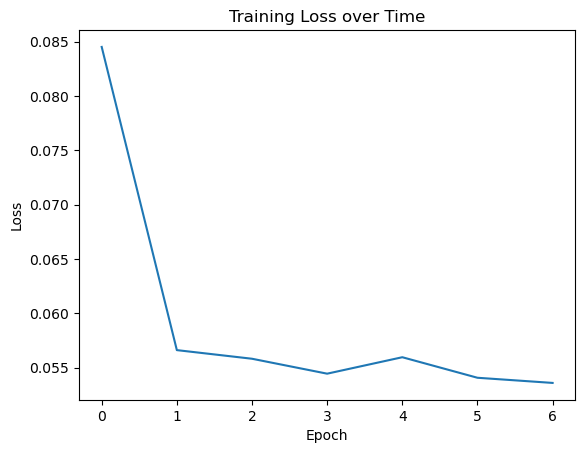

0.053594910805746986


In [52]:
plt.plot(np.arange(len(epochs)), train_losses)
plt.title('Training Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print(train_losses[-1])

In [53]:
PATH = './mnist_medical.pth'
model = ConvNet(1)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [54]:
from torchmetrics.classification import BinaryConfusionMatrix

confusion_mtx = BinaryConfusionMatrix()

outputs = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        output = model(x).squeeze(1)
        pred = output > 0.5
        confusion_mtx.update(pred, y)
        outputs.extend(output)

conf_mat = confusion_mtx.compute().numpy()

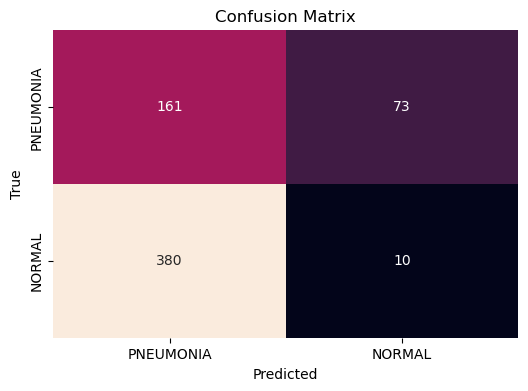

In [55]:
import seaborn as sn

figure = plt.figure(figsize=(6,4))
sn.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['PNEUMONIA', 'NORMAL'], yticklabels=['PNEUMONIA', 'NORMAL'], cbar=False)

plt.xlabel('Predicted')
plt.ylabel('True') 
plt.title('Confusion Matrix')

plt.show()

In [56]:
# Calculate the row and column sums of the confusion matrix
row_sums = conf_mat.sum(axis=1)
col_sums = conf_mat.sum(axis=0)

# Calculate the percentages for each quadrant
TP_percent, FP_percent, FN_percent, TN_percent = [100 * conf_mat[i, j] / row_sums[i] if i == j else 100 * conf_mat[i, j] / col_sums[j] for i in range(2) for j in range(2)]

# Print the results
print(f"TP = {TP_percent:.1f}%\nFP = {FP_percent:.1f}%\nFN = {FN_percent:.1f}%\nTN = {TN_percent:.1f}%")

TP = 68.8%
FP = 88.0%
FN = 70.2%
TN = 2.6%


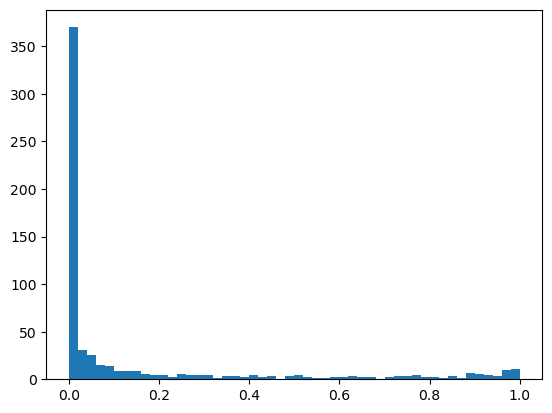

In [58]:
plt.hist(outputs, 50);